# Stranasum data prep - gigaword dataset


In [1]:
%pip install contractions --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset
import operator as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import re
import os
import time
import contractions
SEED = 42

In [3]:
class Preprocessor:
    
    # Text cleanup
    def clean_text(self, text: str):

        # lowercase
        text = str(text).lower()

        # remove &-escaped characters
        text = re.sub(r"&.[1-9]+;"," ", str(text))

        # remove escaped characters
        text=re.sub("(\\t)", ' ', str(text))
        text=re.sub("(\\r)", ' ', str(text))
        text=re.sub("(\\n)", ' ', str(text))

        # remove double characters
        text=re.sub("(__+)", ' ', str(text))  #remove _ if it occurs more than one time consecutively
        text=re.sub("(--+)", ' ', str(text))   #remove - if it occurs more than one time consecutively
        text=re.sub("(~~+)", ' ', str(text))   #remove ~ if it occurs more than one time consecutively
        text=re.sub("(\+\++)", ' ', str(text))  #remove + if it occurs more than one time consecutively
        text=re.sub("(\.\.+)", ' ', str(text))  #remove . if it occurs more than one time consecutively
        
        # fix contractions to base form
        text = contractions.fix(text)

        #remove special tokens <>()|&©ø"',;?~*!
        text=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

        # CNN mail data cleanup
        text=re.sub("(mailto:)", ' ', str(text)) #remove mailto:
        text=re.sub(r"(\\x9\d)", ' ', str(text)) #remove \x9* in text
        text=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)) #replace INC nums to INC_NUM
        text=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(text)) #replace CM# and CHG# to CM_NUM

        # url replacement into base form
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
            repl_url = url.group(3)
            text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(text))
        except:
            pass


        # handle dot at the end of words
        text=re.sub("(\.\s+)", ' ', str(text)) # remove
        
        text=re.sub("(\-\s+)", ' ', str(text)) #remove - at end of words(not between)
        text=re.sub("(\:\s+)", ' ', str(text)) #remove : at end of words(not between)

        #remove multiple spaces
        text=re.sub("(\s+)",' ',str(text))

        # apply lowercase again
        text = text.lower().strip()
        
        # remove trailing dot, we will apply end of sequence anyway
        text = re.sub("(\.)$", '', str(text)).strip()
        
        # gigaword - UNK token
        text = re.sub("unk", '', str(text).strip())
        
        # gigaword - change numbers to hashtags
        text = re.sub("\d", "#", str(text).strip())

        return text

    def apply_special_tokens(self, text):
        text = str(text).strip()
        text = "<sos> " + str(text).strip() + " <eos>"
        return text

    def remove_special_tokens(self, text):
        text = text.lower()
        text = text.replace("<sos>", "").replace("<eos>", "")
        text = text.strip()
        return text

    def plot_approx_lengths(self, df: pd.DataFrame):
        sns.displot(df['article_len_approx']), sns.displot(df['summary_len_approx'])

    # preprocess sentence dataframe from raw format - clean, apply sos/eos tokens
    # - removes articles with length outside bounds
    def preprocess_frame(self, df: pd.DataFrame, article_len_range, summary_len_range):
        
        print("Preprocessing frame...")

        # apply text cleaning
        df['article'] = df['article'].apply(self.clean_text)
        df['summary'] = df['summary'].apply(self.clean_text)

        # apply special tokens
        df['article'] = df['article'].apply(self.apply_special_tokens)
        df['summary'] = df['summary'].apply(self.apply_special_tokens)

        # simple text length approximation for analysis
        df['article_len_approx'] = df['article'].apply(lambda x: op.countOf(x, ' '))
        df['summary_len_approx'] = df['summary'].apply(lambda x: op.countOf(x, ' '))
        
        print("Original length distribution:")
        self.plot_approx_lengths(df)

        # remove longer than set length
        article_min, article_max = article_len_range
        summary_min, summary_max = summary_len_range
        
        df = df[
            (df['article_len_approx'] <= article_max) &
            (df['article_len_approx'] >= article_min) &
            (df['summary_len_approx'] <= summary_max) &
            (df['summary_len_approx'] >= summary_min)
        ]

        # print plots
        print("After processing length distribution:")
        self.plot_approx_lengths(df)

        return df
    
preprocessor = Preprocessor()

# Test
preprocessor.clean_text("  This text number 612.32 (my text ) isn't ]] very - clean.  it WOULd'Ve been betteR? if, it was ok. it's Hannah 's text ")

'this text number ###.## my text is not very clean it would have been better if it was ok it is hannah s text'

In [4]:
dataset = load_dataset("gigaword")

Generating train split:   0%|          | 0/3803957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/189651 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset['test'].to_pandas()

,document,summary
0,japan 's nec corp. and UNK computer corp. of t...,nec UNK in computer sales tie-up
1,the sri lankan government on wednesday announc...,sri lanka closes schools as war escalates
2,police arrested five anti-nuclear protesters t...,protesters target french research ship
3,factory orders for manufactured goods rose #.#...,us september factory orders up #.# percent
4,the bank of japan appealed to financial market...,bank of UNK UNK for calm in financial markets
...,...,...
1946,migrants should be regarded as a high-risk gro...,migrant people need more aids control efforts ...
1947,the growth rate of indonesia 's manufacturing ...,major news items in leading vietnamese UNK
1948,a mozambican man suspect of murdering jorge UN...,mozambican suspected of killing UNK prison dir...
1949,the us dollar fell to the lower ### yen level ...,dollar falls to lower ### yen level in tokyo


Preprocessing frame...
Original length distribution:
After processing length distribution:


,article,summary,article_len_approx,summary_len_approx
0,<sos> japan s nec corp and computer corp of t...,<sos> nec in computer sales tie-up <eos>,24,7
1,<sos> the sri lankan government on wednesday a...,<sos> sri lanka closes schools as war escalate...,30,8
2,<sos> police arrested five anti-nuclear protes...,<sos> protesters target french research ship <...,27,6
3,<sos> factory orders for manufactured goods ro...,<sos> us september factory orders up #.# perce...,17,8
4,<sos> the bank of japan appealed to financial ...,<sos> bank of for calm in financial markets ...,27,10
...,...,...,...,...
1946,<sos> migrants should be regarded as a high-ri...,<sos> migrant people need more aids control ef...,26,10
1947,<sos> the growth rate of indonesia s manufactu...,<sos> major news items in leading vietnamese <...,33,7
1948,<sos> a mozambican man suspect of murdering jo...,<sos> mozambican suspected of killing prison ...,27,8
1949,<sos> the us dollar fell to the lower ### yen ...,<sos> dollar falls to lower ### yen level in t...,33,10


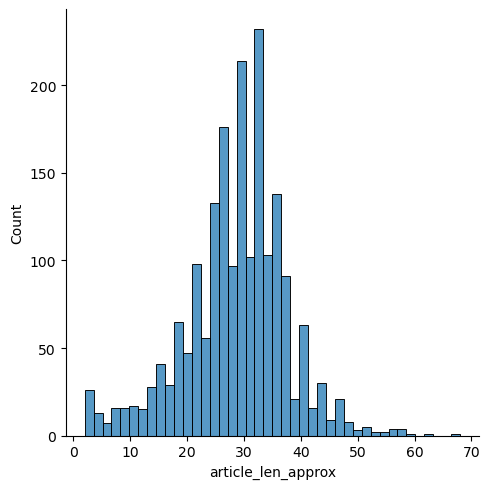

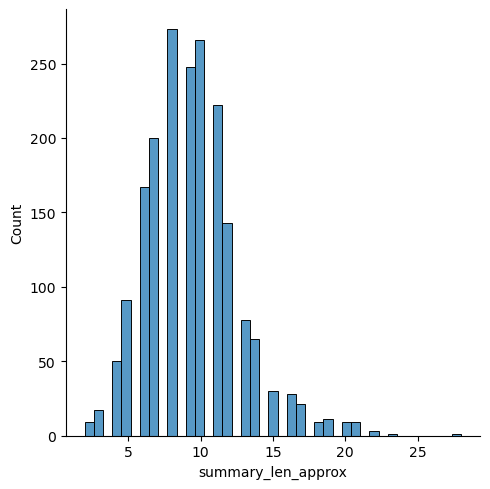

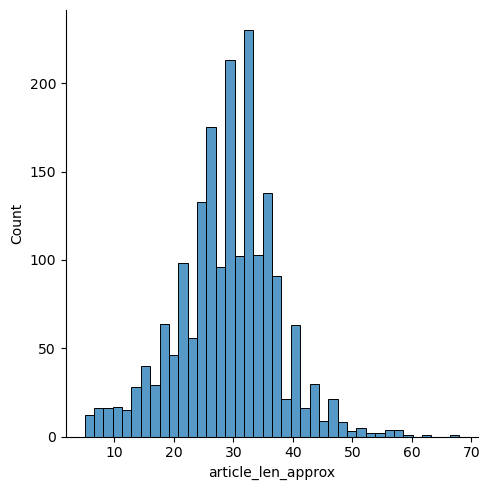

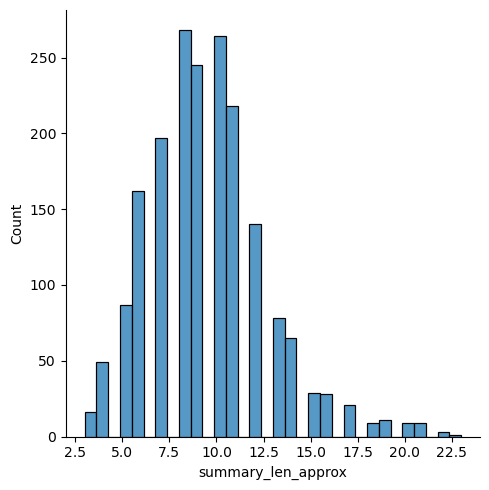

In [6]:
df_test = preprocessor.preprocess_frame(
        dataset['test'].to_pandas().rename({"document": "article", "summary": "summary"}, axis=1).reset_index(drop=True),
        (5, 70),
        (3, 25)
)
df_test

Preprocessing frame...
Original length distribution:
After processing length distribution:


,article,summary,article_len_approx,summary_len_approx
0,<sos> five-time world champion michelle kwan w...,<sos> injury leaves kwan s olympic hopes in li...,32,9
1,<sos> us business leaders lashed out wednesday...,<sos> us business attacks tough immigration la...,17,7
2,<sos> general motors corp said wednesday its u...,<sos> gm december sales fall ## percent <eos>,28,7
3,<sos> several thousand people gathered on wedn...,<sos> thousands of croatians celebrate before ...,39,9
4,<sos> us first lady laura bush and us secretar...,<sos> laura bush rice to attend sirleaf s ina...,36,12
...,...,...,...,...
189646,<sos> thailand s traffic death toll soared to ...,<sos> thailand s traffic death toll during hol...,34,12
189647,<sos> at least seven people were killed on the...,<sos> # killed in blast in southern philippine...,24,8
189648,<sos> survey showed thailand s suicide rate de...,<sos> thailand s suicide rate falls back <eos>,33,7
189649,<sos> the nepali government has announced the ...,<sos> nepal announces #### as export year <eos>,31,7


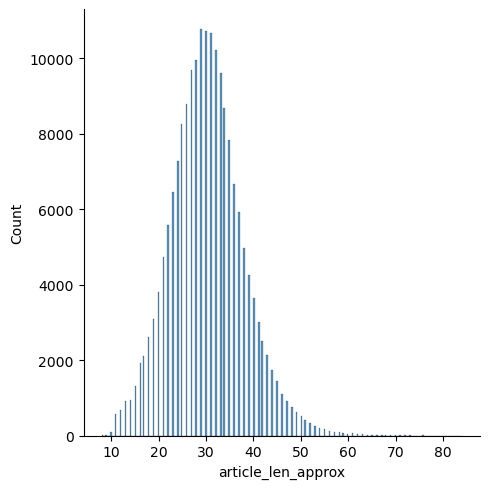

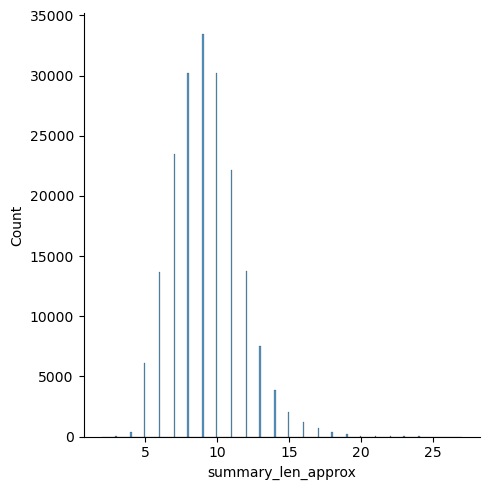

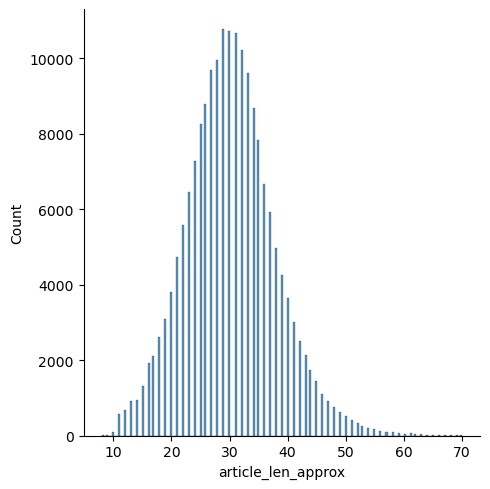

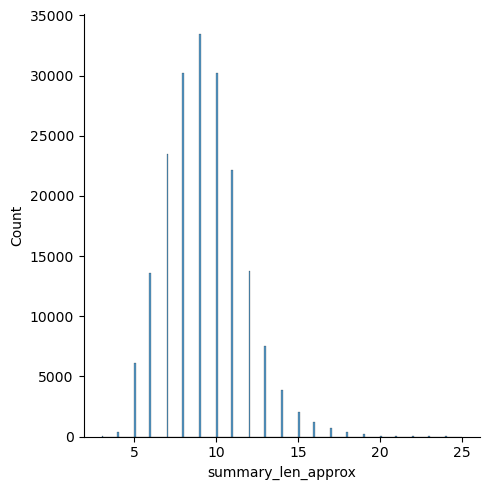

In [7]:
df_val = preprocessor.preprocess_frame(
        dataset['validation'].to_pandas().rename({"document": "article", "summary": "summary"}, axis=1).reset_index(drop=True),
        (5, 70),
        (3, 25)
)
df_val

Preprocessing frame...
Original length distribution:
After processing length distribution:


,article,summary,article_len_approx,summary_len_approx
0,<sos> australia s current account deficit shr ...,<sos> australian current account deficit narro...,31,7
1,<sos> at least two people were killed in a sus...,<sos> at least two dead in southern philippine...,26,9
2,<sos> australian shares closed down #.# percen...,<sos> australian stocks close down #.# percent...,22,7
3,<sos> south korea s nuclear envoy kim sook urg...,<sos> envoy urges north korea to restart nucle...,28,9
4,<sos> south korea on monday announced sweeping...,<sos> skorea announces tax cuts to stimulate e...,26,8
...,...,...,...,...
3803952,<sos> the state duma the lower house of the ru...,<sos> duma urges yeltsin to reconsider troop p...,30,9
3803953,<sos> the you.s justice department today rejec...,<sos> us justice department rejects special pr...,33,8
3803954,<sos> the united nations is calling for ### mi...,<sos> un seeks fund for programs in former yug...,33,9
3803955,<sos> president jacques chirac today won a pre...,<sos> chirac gets birthday gift of ##th centur...,25,9


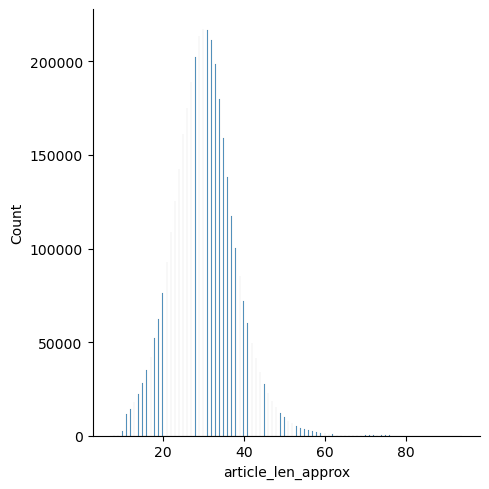

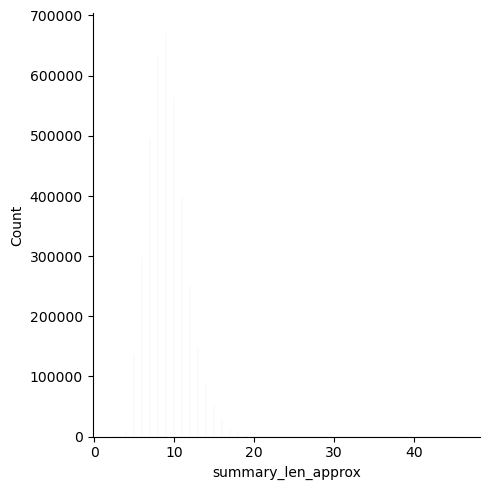

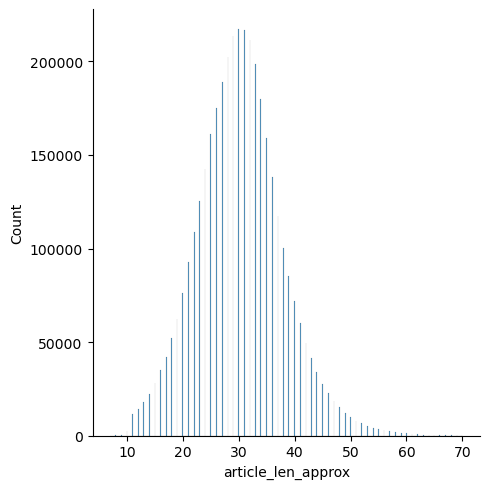

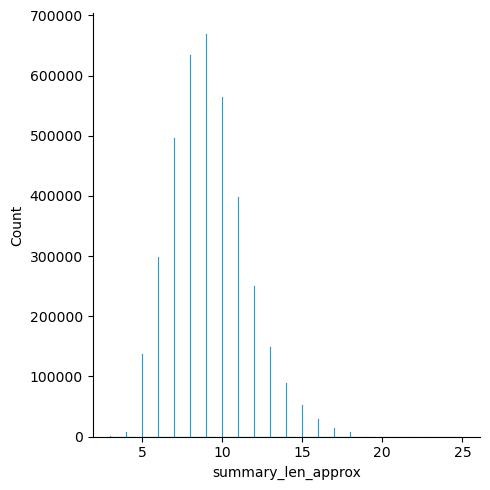

In [8]:
df_train = preprocessor.preprocess_frame(
        dataset['train'].to_pandas().rename({"document": "article", "summary": "summary"}, axis=1).reset_index(drop=True),
        (5, 70),
        (3, 25)
)
df_train

In [9]:
# splits
total = dataset['train'].num_rows + dataset['validation'].num_rows + dataset['test'].num_rows
print("Train: ", dataset['train'].num_rows/total)
print("Validation: ", dataset['validation'].num_rows/total)
print("Test: ", dataset['test'].num_rows/total)

Train:  0.9520462593594539
Validation:  0.0474654485142129
Test:  0.0004882921263332615


In [10]:
df_test.to_csv("gigaword_test.csv")
df_val.to_csv("gigaword_val.csv")
df_train.to_csv("gigaword_train.csv")

In [11]:
print("Done")

Done
